# Generative Adverserial Network for Fake Image Generation

In this Notebook, we will train an FC-GAN to genereate fake Mnist data.

Followed by a conversion of the FC-GAN to DC-GAN, and the generation of higher resolution images.

Gan Paper: https://arxiv.org/abs/1406.2661

PyTorch MNist dataset : https://pytorch.org/docs/stable/torchvision/datasets.html#mnist

Convert FC-Gan To DC-Gan Paper : https://arxiv.org/pdf/1511.06434.pdf

In [5]:
# Import the necessary modules

import os
from typing import Tuple, List

import torch
import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## FC-GAN for the Generation of Fake MNIST Data


In [6]:
# Frist load the MNist dataset from pytorch

def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader

### This is what the MNist data looks like:

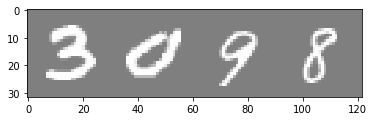

    3     0     9     8


In [7]:
batch_size = 32
trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

img = torchvision.utils.make_grid(images[:4,:,:,:])

# show images
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### The adverserial Networks:



#### The Generative Network:

Input: x values sampled from uniform distribution

Output: 32 x 32 Image, that should look like the data from MNist 

In [8]:
# The Generative Network

class generativeNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 10, out_features=6 * 6)
        
        self.fc2 = nn.Linear(in_features= 6 * 6, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=24 * 24)
        
        self.fc4 = nn.Linear(in_features= 24 * 24, out_features=28 * 28)
        
        self.ReLU = nn.ReLU()
 
    def forward(self, x):
        """
        
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return x
    
G = generativeNet()
G.to(device)

generativeNet(
  (fc1): Linear(in_features=10, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=144, bias=True)
  (fc3): Linear(in_features=144, out_features=576, bias=True)
  (fc4): Linear(in_features=576, out_features=784, bias=True)
  (ReLU): ReLU()
)

#### The discriminative network:

Input: Takes 32 x 32 Image as Input
Output: probability of it being real data (non generated)

In [20]:
class discrimNet(nn.Module):
    """
        The CNN convolutional network with architecture defined above
    """
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features= 28 * 28, out_features=22 * 22)
        
        self.fc2 = nn.Linear(in_features= 22 * 22, out_features=12 * 12)
        
        self.fc3 = nn.Linear(in_features= 12 * 12, out_features=6 * 6)
        
        # 2 class fake and real data
        self.fc4 = nn.Linear(in_features= 6 * 6, out_features=2)
        
        self.ReLU = nn.ReLU()
        
        self.soft = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        """
        Args:
            x: The input tensor with shape [batch_size, feature_dim] (minibatch of data)
        Returns:
            scores: Pytorch tensor of shape (N, C) giving classification scores for x
        """
        
        x = x.view(x.shape[0], 28 * 28)
    
        x = self.fc1(x)
        x = self.ReLU(x)
        x = self.fc2(x)
        x = self.ReLU(x)
        x = self.fc3(x)
        x = self.ReLU(x)
        x = self.fc4(x)        
        return self.soft(x)

D = discrimNet()
D.to(device)

discrimNet(
  (fc1): Linear(in_features=784, out_features=484, bias=True)
  (fc2): Linear(in_features=484, out_features=144, bias=True)
  (fc3): Linear(in_features=144, out_features=36, bias=True)
  (fc4): Linear(in_features=36, out_features=2, bias=True)
  (ReLU): ReLU()
  (soft): Softmax(dim=1)
)

### Define The Noise Prior for the Generative Network:

In [61]:
# Define The Noise Distribution, we us the Gaussian Nosie Distribution:

# always use the same seed to get the same random variables
# np.random.seed(0)

# Here is how to sample a vector of 10 values from uniform distribution
s = np.random.uniform(0,1, 10)
print(s)

[0.58794429 0.20233576 0.79698566 0.71181937 0.36205579 0.59251127
 0.2892727  0.82244205 0.13243784 0.78482592]


### Define new loss function for both networks:


In [36]:
# First define the loss function for the Discriminator Network:

"""
def lossRealData(outputs):
    
    labels = torch.ones(outputs.shape).cuda()
    criterion = nn.BCELoss()
    loss = criterion(outputs, labels)
    return loss
    
def lossFakeData(outputs):
    ones = torch.ones(outputs.shape).cuda()
    labels = torch.zeros(outputs.shape).cuda()
    outputs = torch.abs(ones - outputs)
    cirterion = nn.BCELoss()
    loss = cirterion(outputs,labels)
    return loss
"""

'\ndef lossRealData(outputs):\n    \n    labels = torch.ones(outputs.shape).cuda()\n    criterion = nn.BCELoss()\n    loss = criterion(outputs, labels)\n    return loss\n    \ndef lossFakeData(outputs):\n    ones = torch.ones(outputs.shape).cuda()\n    labels = torch.zeros(outputs.shape).cuda()\n    outputs = torch.abs(ones - outputs)\n    cirterion = nn.BCELoss()\n    loss = cirterion(outputs,labels)\n    return loss\n'

In [12]:
# function for sampling the noise data

def sample_noise(batch_size=batch_size):
    noise_batch = []
    for i in range(batch_size):
        s = np.random.uniform(0,1, 10) # 10 values sample from uniform distribution
        noise_batch.append(s)

    noise_batch = torch.from_numpy(np.asarray(noise_batch)).float() 
    return noise_batch

### Train the Networks:

In [13]:
torch.cuda.get_device_capability(device=None)
torch.cuda.get_device_name(device=None)

'GeForce GTX 1050'

In [42]:
# calculate the real labels
a_real = []
a_fake = []
for i in range(batch_size):
    sub1 = [1]
    sub2 = [0]
    for j in range(1):
        sub1.append(0)
        sub2.append(1)
    a_real.append(sub1)
    a_fake.append(sub2)

labels_real = torch.tensor(a_real, dtype=torch.float).cuda()
labels_fake = torch.tensor(a_fake, dtype=torch.float).cuda()

In [50]:
# Define a Loss function and optimizer
optimizer1 = optim.SGD(D.parameters(), lr=0.001, momentum=0.9)
optimizer2 = optim.SGD(G.parameters(), lr=0.001, momentum=0.9)
# k = discriminator interations
k = 3

criterion = nn.BCELoss()

# Train the network
for epoch in range(100):
    print("Currently running epoch Nbr %d" % epoch)
    
    # train D for k iterations 
    for d in range(k):
        #print("\tRunning D iteration Nbr %d" % d)
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer1.zero_grad()
            # sample batch_size * 10 matrix of uniform distributed noise
            noise = sample_noise(batch_size).to(device)
            outputs_fake = D(G(noise).detach())
            outputs_real = D(inputs)
            loss = criterion(outputs_real, labels_real) + criterion(outputs_fake, labels_fake)
            loss.backward()
            optimizer1.step()
            running_loss += loss.item()
            if i % 100 == 99:   # print every 1000 mini-batches
                print('\t[%d, %5d] D loss: %.9f' %
                      (d + 1, i + 1, running_loss / 99))
                running_loss = 0.0

    # 1 training step for G
    print("\t\t Running %dth iteration on G" % epoch)
    optimizer2.zero_grad()
    noise = sample_noise(batch_size).to(device)
    loss = criterion(D(G(noise)), labels_fake)
    loss.backward()
    optimizer2.step()
    print("\t\t G Loss is : %.9f" % loss.item())

print('Finished Training')

Currently running epoch Nbr 0
	[1,   100] D loss: 0.000037751
	[1,   200] D loss: 0.000042724
	[2,   100] D loss: 0.000040527
	[2,   200] D loss: 0.000041352
	[3,   100] D loss: 0.000038777
	[3,   200] D loss: 0.000042515
		 Running 0th iteration on G
		 G Loss is : 0.000032329
Currently running epoch Nbr 1
	[1,   100] D loss: 0.000036162
	[1,   200] D loss: 0.000044478
	[2,   100] D loss: 0.000040552
	[2,   200] D loss: 0.000039435
	[3,   100] D loss: 0.000037328
	[3,   200] D loss: 0.000040958
		 Running 1th iteration on G
		 G Loss is : 0.000031757
Currently running epoch Nbr 2
	[1,   100] D loss: 0.000037318
	[1,   200] D loss: 0.000038580
	[2,   100] D loss: 0.000038384
	[2,   200] D loss: 0.000039702
	[3,   100] D loss: 0.000040081
	[3,   200] D loss: 0.000039515
		 Running 2th iteration on G
		 G Loss is : 0.000030719
Currently running epoch Nbr 3
	[1,   100] D loss: 0.000036106
	[1,   200] D loss: 0.000039026
	[2,   100] D loss: 0.000036617
	[2,   200] D loss: 0.000036652
	[3, 

	[2,   100] D loss: 0.000024029
	[2,   200] D loss: 0.000025993
	[3,   100] D loss: 0.000026466
	[3,   200] D loss: 0.000023472
		 Running 29th iteration on G
		 G Loss is : 0.000020413
Currently running epoch Nbr 30
	[1,   100] D loss: 0.000025225
	[1,   200] D loss: 0.000025874
	[2,   100] D loss: 0.000024464
	[2,   200] D loss: 0.000025545
	[3,   100] D loss: 0.000024931
	[3,   200] D loss: 0.000024563
		 Running 30th iteration on G
		 G Loss is : 0.000020049
Currently running epoch Nbr 31
	[1,   100] D loss: 0.000023694
	[1,   200] D loss: 0.000023242
	[2,   100] D loss: 0.000025735
	[2,   200] D loss: 0.000024762
	[3,   100] D loss: 0.000026091
	[3,   200] D loss: 0.000025363
		 Running 31th iteration on G
		 G Loss is : 0.000019440
Currently running epoch Nbr 32
	[1,   100] D loss: 0.000023871
	[1,   200] D loss: 0.000024106
	[2,   100] D loss: 0.000025392
	[2,   200] D loss: 0.000024233
	[3,   100] D loss: 0.000022826
	[3,   200] D loss: 0.000026618
		 Running 32th iteration on 

	[3,   100] D loss: 0.000018780
	[3,   200] D loss: 0.000018721
		 Running 58th iteration on G
		 G Loss is : 0.000014596
Currently running epoch Nbr 59
	[1,   100] D loss: 0.000017894
	[1,   200] D loss: 0.000019436
	[2,   100] D loss: 0.000018616
	[2,   200] D loss: 0.000018571
	[3,   100] D loss: 0.000018303
	[3,   200] D loss: 0.000017535
		 Running 59th iteration on G
		 G Loss is : 0.000014601
Currently running epoch Nbr 60
	[1,   100] D loss: 0.000016830
	[1,   200] D loss: 0.000018230
	[2,   100] D loss: 0.000016738
	[2,   200] D loss: 0.000017650
	[3,   100] D loss: 0.000018871
	[3,   200] D loss: 0.000017774
		 Running 60th iteration on G
		 G Loss is : 0.000014234
Currently running epoch Nbr 61
	[1,   100] D loss: 0.000017233
	[1,   200] D loss: 0.000017782
	[2,   100] D loss: 0.000017059
	[2,   200] D loss: 0.000018577
	[3,   100] D loss: 0.000018093
	[3,   200] D loss: 0.000018512
		 Running 61th iteration on G
		 G Loss is : 0.000014342
Currently running epoch Nbr 62
	[1,

		 Running 87th iteration on G
		 G Loss is : 0.000011130
Currently running epoch Nbr 88
	[1,   100] D loss: 0.000015709
	[1,   200] D loss: 0.000013200
	[2,   100] D loss: 0.000013019
	[2,   200] D loss: 0.000014962
	[3,   100] D loss: 0.000014003
	[3,   200] D loss: 0.000013517
		 Running 88th iteration on G
		 G Loss is : 0.000011011
Currently running epoch Nbr 89
	[1,   100] D loss: 0.000014031
	[1,   200] D loss: 0.000014417
	[2,   100] D loss: 0.000013972
	[2,   200] D loss: 0.000014184
	[3,   100] D loss: 0.000012755
	[3,   200] D loss: 0.000014205
		 Running 89th iteration on G
		 G Loss is : 0.000011113
Currently running epoch Nbr 90
	[1,   100] D loss: 0.000012769
	[1,   200] D loss: 0.000015181
	[2,   100] D loss: 0.000014334
	[2,   200] D loss: 0.000013797
	[3,   100] D loss: 0.000013776
	[3,   200] D loss: 0.000013213
		 Running 90th iteration on G
		 G Loss is : 0.000011230
Currently running epoch Nbr 91
	[1,   100] D loss: 0.000013245
	[1,   200] D loss: 0.000014251
	[2,

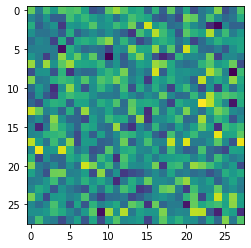

tensor([[1.1523e-05, 9.9999e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
tensor([[1.0000e+00, 2.6877e-07]], device='cuda:0', grad_fn=<SoftmaxBackward>)


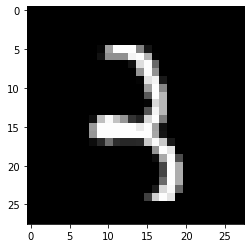

In [72]:
s = sample_noise(1).cuda()

a = G(s)

a = torch.reshape(G(s), (28,28)).cpu()
img = torchvision.utils.make_grid(a)

img = img / 2 + 0.5     # unnormalize
npimg = img.detach().numpy()
#plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.imshow(np.transpose(a.detach().numpy(), (0, 1)))
plt.show()


print(D(G(s).detach()))


trainloader, validation_loader, test_loader = load_mnist_minibatched(batch_size)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(D(images[0].to(device)))

img = torchvision.utils.make_grid(images[0])

#img = img / 2 + 0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
